# 개요

이 커널은 연구용입니다.
목표는 정확도 0.9입니다.

In [101]:
import numpy as np
import pandas as pd
import re

import matplotlib as mlt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


# 데이터 로드 후 구조 확인

train, test data는 종속변수인 Survived를 제외하고 컬럼이 동일한 것을 알 수 있다.

In [102]:
# 데이터 로드
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# 컬럼 확인
print(train.columns)
print(test.columns)

# 다른 컬럼 확인
print(set(train.columns)-set(test.columns))
print(set(test.columns)-set(train.columns))

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
{'Survived'}
set()


Data head Confirm

In [103]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [104]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [105]:
train.shape, test.shape

((891, 12), (418, 11))

Missing Data

In [106]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Add driven variable (count(NA))

In [107]:
train['na_count'] = np.sum(train.isnull(), axis=1)

In [108]:
test['na_count'] = np.sum(test.isnull(), axis=1)

Missing value fill

In [109]:
train['Age'] = train['Age'].fillna(round(np.mean(train['Age'])))
train['Cabin'] = train['Cabin'].fillna('no value')
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].value_counts().index[0])

test['Age'] = test['Age'].fillna(round(np.mean(test['Age'])))
test['Fare'] = test['Fare'].fillna(round(np.mean(test['Fare'])))
test['Cabin'] = test['Cabin'].fillna('no value')

In [110]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
na_count       0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
na_count       0
dtype: int64


# Y value


0    549
1    342
Name: Survived, dtype: int64


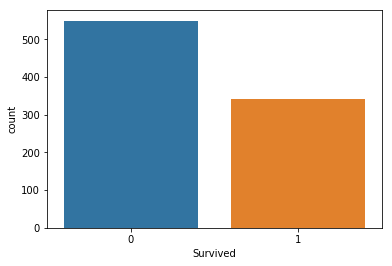

In [111]:
print(train['Survived'].value_counts())
sns.countplot(x='Survived', data=train)

# X value

In [112]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'na_count'],
      dtype='object')

PassengerId is distinct, so delete

In [113]:
print(train['PassengerId'].value_counts().value_counts())
print(test['PassengerId'].value_counts().value_counts())

train = train.drop(columns = 'PassengerId')
test = test.drop(columns = 'PassengerId')

1    891
Name: PassengerId, dtype: int64
1    418
Name: PassengerId, dtype: int64


Pclass

- 위의 그래프를 보았을 때, Pclass가 1st 일때가 2nd, 3rd보다 생존률이 낮은 것으로 보인다.
- 높은 Pclass일 때, 생존율이 낮다. 왜 그럴까? 이것인 Ticket을 확인할 필요도 보인다.

Text(0.5,1,'test Pclass')

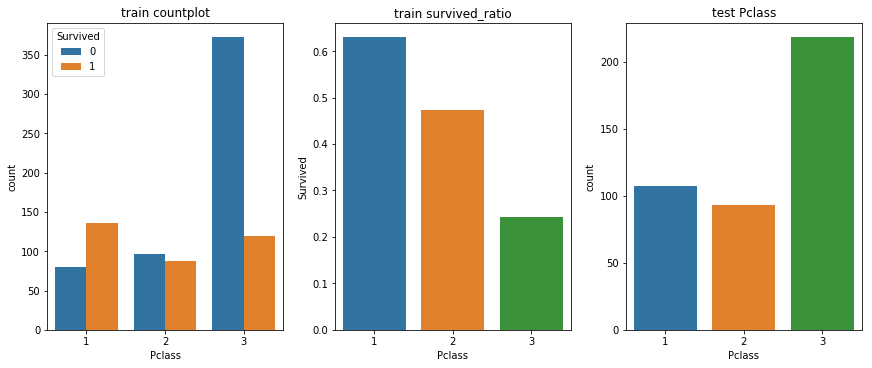

In [114]:
fig, axes = plt.subplots(1,3, figsize=(12,5), constrained_layout=True)

sns.countplot(x="Pclass", data=train, hue='Survived', ax=axes[0]).set_title('train countplot')
sns.barplot(x="Pclass", y='Survived', data=train.groupby('Pclass').mean()['Survived'].reset_index(), ax=axes[1]).set_title('train survived_ratio')
sns.countplot(x="Pclass", data=test, ax=axes[2]).set_title('test Pclass')

Name

- 이름은 유니크한 값을 가짐
- 이름의 구조는 first name, title. last name으로 구성되는 것으로 보인다.
- title이 유의미한 값을 가지기에 정규표현식을 사용하여 tilte을 추출한다.
- 또한 이름의 길이가 유의미할까를 생각해 보았다. 이름의 길이가 길 수록 귀족일 확률이 있는 것인가? 혹은 부호일 가능성이 있는지에 대한 궁금증

In [115]:
print(len(train['Name'])==len(np.unique(train['Name'])))

True


In [116]:
# Name length column
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

- Pclass가 Ticket class를 의미하므로, 이름의 길이가 Pclass에 영향을 끼치는 가?(많은 재력을 가지고 있는가)
- Fare 또한 운임비용으로써 재력을 상징할 수 도 있으나, 3rd를 비싼값에 주고 사는 것이 재력가인가를 생각해 보았을 때, 아니다라고 생각했다.

Text(0.5,1,'3rd')

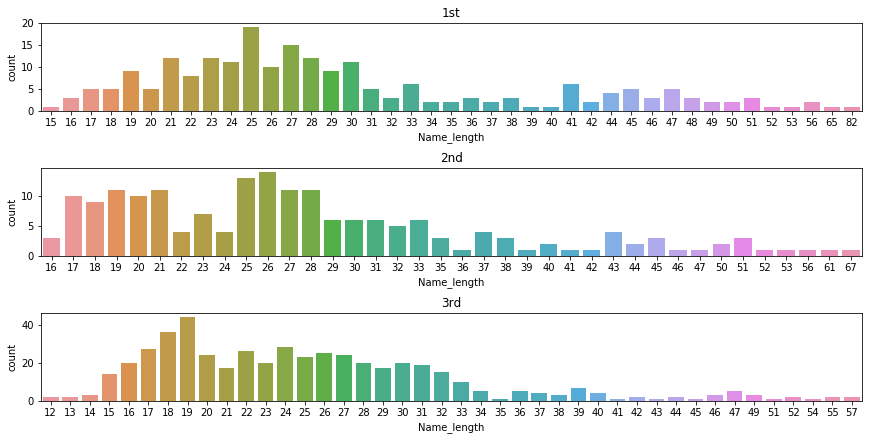

In [117]:
fig, axes = plt.subplots(3,1, figsize=(12,6), constrained_layout=True)

sns.countplot(x="Name_length", data=train[train['Pclass']==1], ax=axes[0]).set_title('1st')
sns.countplot(x="Name_length", data=train[train['Pclass']==2], ax=axes[1]).set_title('2nd')
sns.countplot(x="Name_length", data=train[train['Pclass']==3], ax=axes[2]).set_title('3rd')

- 대체적으로 1st, 2nd가 3rd보다 우측꼬리가 좀더 두터운 것을 볼 수 있다.

extract title

In [118]:
train['name_title'] = train['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))
test['name_title'] = test['Name'].apply(lambda x: re.search('([A-Za-z]+)\.', x).group(1))

Text(0.5,1,'test name_title')

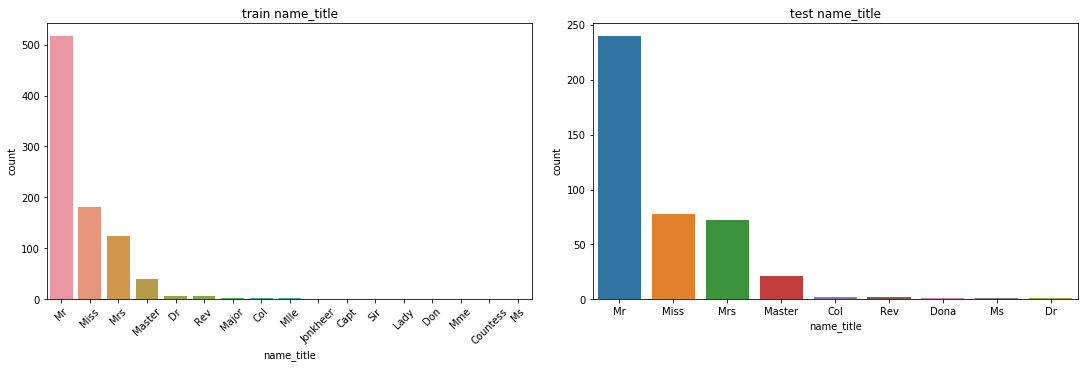

In [119]:
fig, axes = plt.subplots(1,2, figsize=(15,5), constrained_layout=True)

a = sns.countplot(x="name_title", data=train, order=train['name_title'].value_counts().index, ax=axes[0])
a.set_xticklabels(labels=train['name_title'].value_counts().index, rotation=45)
a.set_title('train name_title')
sns.countplot(x="name_title", data=test, order=test['name_title'].value_counts().index, ax=axes[1]).set_title('test name_title')

- 겹치지 않는 부분이 있어, 서로 공통으로 가지지 않는 컬럼에 대해 etc로 변환한다.

In [120]:
train.loc[~train['name_title'].isin(test['name_title']), 'name_title'] = 'etc'
test.loc[~test['name_title'].isin(train['name_title']), 'name_title'] = 'etc'

Text(0.5,1,'test name_title')

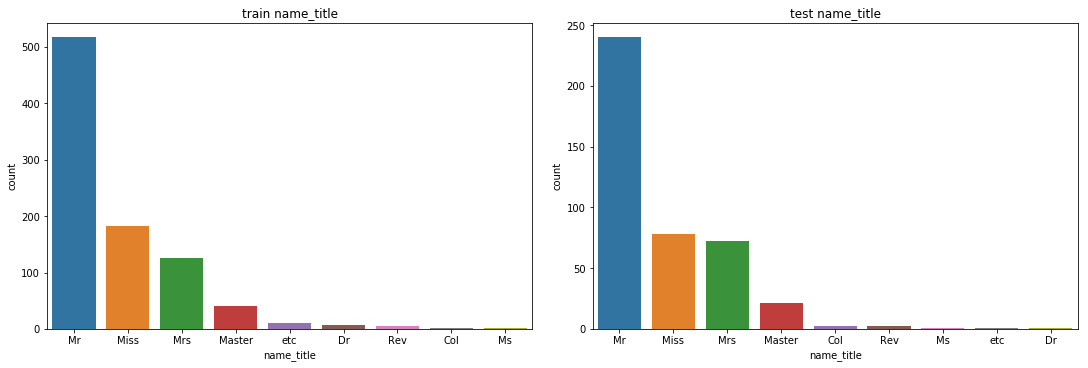

In [121]:
fig, axes = plt.subplots(1,2, figsize=(15,5), constrained_layout=True)

sns.countplot(x="name_title", data=train, order=train['name_title'].value_counts().index, ax=axes[0]).set_title('train name_title')
sns.countplot(x="name_title", data=test, order=test['name_title'].value_counts().index, ax=axes[1]).set_title('test name_title')

Sex
- basemodel을 만들어본 결과 강력한 변수 중 하나이다.
- 남성의 경우 죽을 확률이 매우 높고, 여성의 경우 생존확률이 남성보다 높음을 알 수 있다.

Text(0.5,1,'test Pclass')

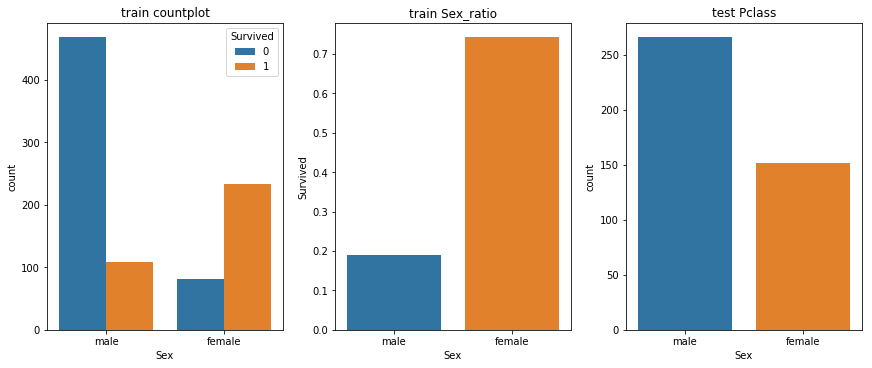

In [122]:
fig, axes = plt.subplots(1,3, figsize=(12,5), constrained_layout=True)

sns.countplot(x="Sex", data=train, hue='Survived', ax=axes[0]).set_title('train countplot')
sns.barplot(x="Sex", y='Survived', data=train.groupby('Sex').mean()['Survived'].reset_index(), order=['male', 'female'], ax=axes[1]).set_title('train Sex_ratio')
sns.countplot(x="Sex", data=test, ax=axes[2]).set_title('test Pclass')

- Interaction effect를 이용하면 어떨까..?

Age

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


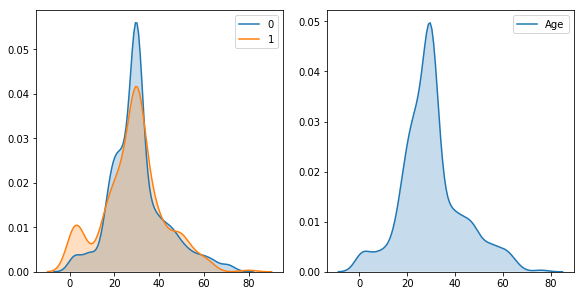

In [123]:
fig, axes = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)

for val in [0, 1]:
    sns.kdeplot(train.loc[train['Survived']==val, 'Age'], shade=True, label=val, ax=axes[0])

sns.kdeplot(data=test['Age'], shade=True, ax=axes[1])

- 20세 이하인 경우 사망확률이 높은 것을 볼 수 있다. 이 점을 이용하기 위해 연속형 변수 보다는 카테고리컬 변수가 더 효과적인 것으로 보인다.

In [124]:
train['cate_age'] = pd.cut(train['Age'], [0, 15, 25, 40, 60, np.max(train['Age'])], labels=[1, 2, 3, 4, 5])
test['cate_age'] = pd.cut(test['Age'], [0, 15, 25, 40, 60, np.max(train['Age'])], labels=[1, 2, 3, 4, 5])

- train data를 보았을 때, 약 4개의 봉우리가 보이는데, 그 봉우리를 기준으로 위의 bins기준을 세웠다.

sibsp and parch

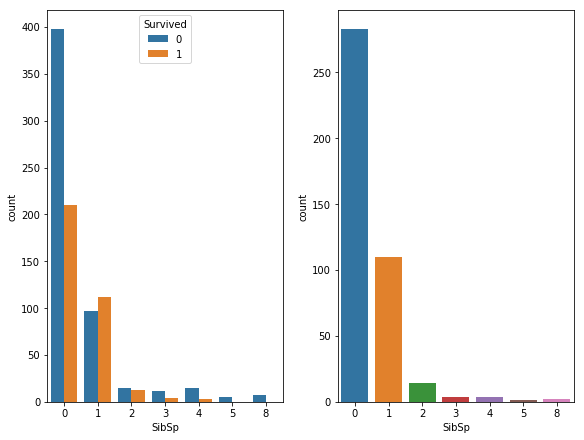

In [125]:
fig, axes = plt.subplots(1,2, figsize=(8,6), constrained_layout=True)

sns.countplot(x='SibSp', data=train, hue='Survived', ax=axes[0])
sns.countplot(x='SibSp', data=test, ax=axes[1])

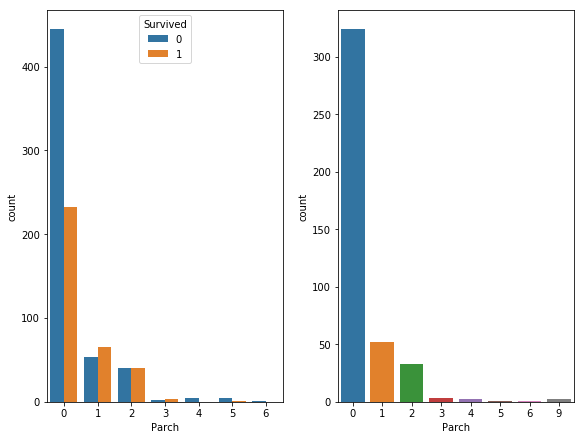

In [126]:
fig, axes = plt.subplots(1,2, figsize=(8,6), constrained_layout=True)

sns.countplot(x='Parch', data=train, hue='Survived', ax=axes[0])
sns.countplot(x='Parch', data=test, ax=axes[1])

- sibsp	# of siblings / spouses aboard the Titanic
- parch	# of parents / children aboard the Titanic
- 이므로 두 컬럼은 유사한 성격을 가지고 있다고 볼 수 있다.
- 눈여겨 볼 수 있는 부분은 Parch와 SiSap가 0명일 때, 생존율이 높은 것을 알 수 있다.

In [127]:
train['family_size'] = train['SibSp'] + train['Parch']
test['family_size'] = test['SibSp'] + test['Parch']

- family_size컬럼의 경우 SibSp와 Parch의 합으로 써 가족의 규모를 뜻한다.

In [128]:
crosstab_family_size = pd.crosstab(train['Ticket'], train['family_size'])
crosstab_family_size.loc[np.count_nonzero(crosstab_family_size==0, axis=1)!=8, ]

family_size,0,1,2,3,4,5,6,7,10
Ticket,,,,,,,,,
113781,1,0,0,3,0,0,0,0,0
11767,1,1,0,0,0,0,0,0,0
12749,1,0,1,0,0,0,0,0,0
13502,1,2,0,0,0,0,0,0,0
16966,1,0,1,0,0,0,0,0,0
17421,1,0,3,0,0,0,0,0,0
19877,1,1,0,0,0,0,0,0,0
19928,0,1,1,0,0,0,0,0,0
24160,1,2,0,0,0,0,0,0,0


- 티켓번호에 따라 family size가 정해지는 것이 아님을 알 수 있다.
- 그렇다면, family size은 사망률에 영향을 주는가?

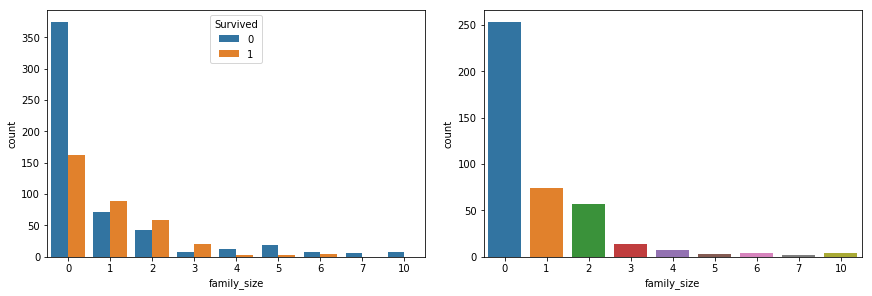

In [129]:
fig, axes = plt.subplots(1,2, figsize=(12,4), constrained_layout=True)

sns.countplot(x='family_size', data=train, hue='Survived', ax=axes[0])
sns.countplot(x='family_size', data=test, ax=axes[1])

- family_size가 1, 2, 3인경우에 사망률이 높다.
- 그러므로 [0, 4, 5, 6, 7, 10]과 [1, 2, 3]을 그룹핑한다.

In [130]:
train.loc[train['family_size'].isin([0, 4, 5, 6, 7, 10]), 'family_size'] = 0
train.loc[train['family_size'].isin([1, 2, 3]), 'family_size'] = 1

In [131]:
test.loc[test['family_size'].isin([0, 4, 5, 6, 7, 10]), 'family_size'] = 0
test.loc[test['family_size'].isin([1, 2, 3]), 'family_size'] = 1

Ticket
- 티켓은 가족이라면 동일한가?
- 티켓이 같을 때 운임비용이 같다면, 가족이라고 판단할 수 있을까

In [163]:
train.groupby('Ticket').mean()['Survived'].value_counts()

0.000000    421
1.000000    211
0.500000     32
0.666667     11
0.750000      3
0.714286      1
0.333333      1
0.250000      1
Name: Survived, dtype: int64

In [133]:
train[['Ticket', 'Fare']]

,Ticket,Fare
0,A/5 21171,7.2500
1,PC 17599,71.2833
2,STON/O2. 3101282,7.9250
3,113803,53.1000
4,373450,8.0500
5,330877,8.4583
6,17463,51.8625
7,349909,21.0750
8,347742,11.1333
9,237736,30.0708


조금 더 연구가 필요한 컬럼이다.

In [134]:
# Ticket length column
train['Ticket_length'] = train['Ticket'].apply(len)
test['Ticket_length'] = test['Ticket'].apply(len)

Cabin

In [135]:
train['Cabin'].value_counts()

no value           687
C23 C25 C27          4
B96 B98              4
G6                   4
E101                 3
D                    3
F33                  3
F2                   3
C22 C26              3
B58 B60              2
D36                  2
B22                  2
B77                  2
F4                   2
E24                  2
B35                  2
B57 B59 B63 B66      2
C65                  2
B20                  2
E33                  2
C68                  2
B28                  2
C52                  2
C2                   2
E121                 2
F G73                2
B18                  2
C124                 2
C92                  2
D33                  2
                  ... 
E10                  1
C118                 1
C110                 1
A34                  1
C85                  1
A20                  1
B38                  1
B39                  1
C7                   1
E50                  1
E40                  1
A6                   1
B94        

In [136]:
train['Cabin_first'] = train['Cabin'].apply(lambda x: x[0])
test['Cabin_first'] = test['Cabin'].apply(lambda x: x[0])

- 티켓과 마찬가지로 생각이 더 필요하다.

embarked

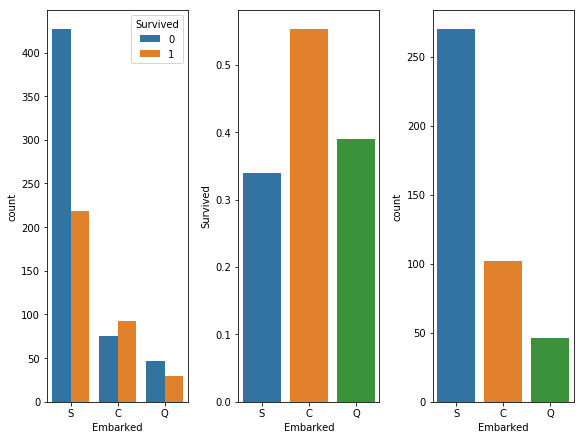

In [137]:
fig, axes = plt.subplots(1,3, figsize=(8,6), constrained_layout=True)

sns.countplot(x='Embarked', data=train, hue='Survived', ax=axes[0])
sns.barplot(x='Embarked', y='Survived', data=train.groupby('Embarked').mean()['Survived'].reset_index(), order=['S', 'C', 'Q'], ax=axes[1])
sns.countplot(x='Embarked', data=test, order=['S', 'C', 'Q'], ax=axes[2])

survived ratio

In [138]:
a = train.groupby(['cate_age', 'Pclass', 'Sex']).mean()['Survived']

In [143]:
a = a.fillna(0).reset_index()

In [146]:
a.columns = ['cate_age', 'Pclass', 'Sex', 'est_Survived']

In [147]:
train = pd.merge(train, a, how='left', on=['cate_age', 'Pclass', 'Sex'])

In [148]:
test = pd.merge(test, a, how='left', on=['cate_age', 'Pclass', 'Sex'])

---

# features

In [149]:
features = ['Name_length', 'est_Survived', 'Pclass', 'Sex', 'Embarked', 'na_count', 'name_title', 'cate_age', 'family_size']

In [150]:
train2 = train[features]
test2 = test[features]

# lebeling

In [151]:
label = LabelEncoder()

df = pd.concat([train2, test2])

for i in ['Sex', 'Embarked', 'name_title']:
    df[i] = label.fit_transform(df[i])

In [153]:
train2 = df.iloc[:891, :]
test2 = df.iloc[891:, :]

# one hot encoding

In [157]:
train2 = pd.concat([train['Survived'], train2.iloc[:, :2], pd.get_dummies(train2.iloc[:, 2:].astype(object))], axis=1)

In [158]:
test2 = pd.concat([test2.iloc[:, :2], pd.get_dummies(test2.iloc[:, 2:].astype(object))], axis=1)

# Modeling

## Random Forest

In [159]:
def rf_model(train_val, test_val):
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=100).fit(
    train_val.drop(columns=['Survived']), train_val['Survived'])
    
    test_val_y = regr.predict(test_val.drop(columns=['Survived'])) > decision_boundary
    test_val_y = test_val_y.astype(int)
    
    true_count = 0
    for i in test_val_y - test_val['Survived']:
        if i == 0:
            true_count+=1
    
    return true_count/len(test_val_y)

# 5-fold

In [160]:
cv = KFold(5, shuffle=True, random_state=0)

for j in range(2, 9):
    for k in range(30, 51):
        L = []
        for i, (idx_train, idx_test) in enumerate(cv.split(train2)):
            train_val = train2.iloc[idx_train]
            test_val = train2.iloc[idx_test]
            
            max_depth=j
            decision_boundary=k/100
            
            L.append(rf_model(train_val, test_val))
            if np.mean(L) > .83:
                print('accuacy : {}, max_depth : {}, decision boundary : {}'.format(np.mean(L), j, k/100))


accuacy : 0.8379888268156425, max_depth : 3, decision boundary : 0.5
accuacy : 0.8435754189944135, max_depth : 4, decision boundary : 0.49
accuacy : 0.83175360408428, max_depth : 4, decision boundary : 0.49
accuacy : 0.8491620111731844, max_depth : 4, decision boundary : 0.5
accuacy : 0.8336158014772037, max_depth : 4, decision boundary : 0.5
accuacy : 0.8302680308831837, max_depth : 4, decision boundary : 0.5
accuacy : 0.8324022346368715, max_depth : 5, decision boundary : 0.48
accuacy : 0.8379888268156425, max_depth : 5, decision boundary : 0.49
accuacy : 0.8435754189944135, max_depth : 5, decision boundary : 0.5


## Xgboost

## 5-fold CV

cv = KFold(5, shuffle=True, random_state=0)
L = []
for i, (idx_train, idx_test) in enumerate(cv.split(train)):
    train_val = train.iloc[idx_train]
    test_val = train.iloc[idx_test]

    L.append(xgb_model(train_val, test_val))
    
print(np.mean(L)) 

## Save Submission

### Random Forest

In [161]:
regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=100).fit(
    train2[test2.columns], train2['Survived'])
test_y = regr.predict(test2)
test_y = test_y > .5
predictions = test_y.astype(int)
test_PassengerId = pd.read_csv('../input/gender_submission.csv')['PassengerId']
submission = pd.concat([pd.DataFrame(test_PassengerId), pd.DataFrame({'Survived':predictions})], axis=1)
submission.to_csv("submission_rf4.csv", index=False)

### Xgboost

### ensembles